随着我们设计越来越深的网络，深刻理解“新添加的层如何提升神经网络的性能”变得至关重要。更重要的是设计网络的能力，在这种网络中，添加层会使网络更具表现力

只有当较复杂的函数类包含较小的函数类时，我们才能确保提高它们的性能
对于非嵌套函数类，较复杂（由较大区域表示）的函数类不能保证更接近“真”函数（f*）。这种现象在嵌套函数类中不会发生。
同时，由于新模型可能得出更优的解来拟合训练数据集，因此添加层似乎更容易降低训练误差。

残差网络的核心思想是：每个附加层都应该更容易地包含原始函数作为其元素之一。 于是，残差块（residual blocks）便诞生了，这个设计对如何建立深层神经网络产生了深远的影响。

恒等映射（Identity Mapping）：
    直接将输入 x 传递到输出，不做任何变换
    数学表示为：f(x) = x
    在残差块中体现为"跳跃连接"或"快捷路径"

残差映射（Residual Mapping）：
    学习输入与目标输出之间的差异（即"残差"）
    数学表示为：F(x) = H(x) - x，其中 H(x) 是期望的输出映射
    通过神经网络层来拟合这个差异

残差块的完整表达式：
    y = F(x) + x：输出等于残差函数加上输入本身
    其中 F(x) 通常由几个卷积层组成

作用：
解决深层网络的退化问题：
    传统深层网络面临的问题：随着深度增加，准确率反而下降
    这种现象并非过拟合，而是优化难度增加

优化角度的理解：
    如果理想映射接近恒等映射，学习残差比直接学习目标函数更容易
    例如：若最优映射是 H(x) = x + 0.1，直接学习 F(x) = 0.1 比学习 H(x) = x + 0.1 更简单

梯度流的改善：
    跳跃连接创建了梯度的"高速公路"
    使得梯度可以直接向前或向后流动
    缓解了深层网络中的梯度消失/爆炸问题

网络退化的优雅解决方案：
    如果额外的层无益，系统可以简单地学习 F(x) ≈ 0
    这样输出就近似于 y ≈ x，即保留输入信息
    确保增加网络深度至少不会降低性能

嵌套函数类的保证：
    残差设计确保了更深的网络能力至少不低于浅层网络
    因为残差块可以简单退化为恒等映射

学习嵌套函数（nested function）是训练神经网络的理想情况。在深层神经网络中，学习另一层作为恒等映射（identity function）较容易（尽管这是一个极端情况）。

残差映射可以更容易地学习同一函数，例如将权重层中的参数近似为零。

利用残差块（residual blocks）可以训练出一个有效的深层神经网络：输入可以通过层间的残余连接更快地向前传播。

残差网络（ResNet）对随后的深层神经网络设计产生了深远影响。

ResNet沿用了VGG完整的3x3卷积层设计。 残差块里首先有2个有相同输出通道数的3x3卷积层。 每个卷积层后接一个批量规范化层和ReLU激活函数。 
然后我们通过跨层数据通路，跳过这2个卷积运算，将输入直接加在最后的ReLU激活函数前。 这样的设计要求2个卷积层的输出与输入形状一样，从而使它们可以相加。 如果想改变通道数，就需要引入一个额外的1x1卷积层来将输入变换成需要的形状后再做相加运算。 残差块的实现如下：

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l


class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None

        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))  # 主路径第一步：通过第一个卷积层并使用批量归一化和ReLU激活函数
        Y = self.bn2(self.conv2(Y))
        if self.conv3:  # 快捷路径上，如果需要调整输入形状（通道或者分辨率），则使用1x1卷积
            X = self.conv3(X)
        Y += X  # 残差连接，将主路径输出Y和快捷路径X相加
        return F.relu(Y)  # 此时再使用ReLU激活函数

下面作为示例

输入和输出形状一致时，不需要使用1x1卷积层

In [2]:
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

如果增加了输出通道，那么要对原始X进行调整，同时也可以通过调正步幅来减半输出的高和宽

In [3]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

ResNet模型

前两层和GoogLenet中类似，都使用了卷积层和最大汇聚层，不过这里在卷积层后还增加了批量规范化层

In [4]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

GoogLeNet在后面接了4个由Inception块组成的模块。 
ResNet则使用4个由残差块组成的模块，每个模块使用若干个同样输出通道数的残差块。 
第一个模块的通道数同输入通道数一致。 由于之前已经使用了步幅为2的最大汇聚层，所以无须减小高和宽。 之后的每个模块在第一个残差块里将上一个模块的通道数翻倍，并将高和宽减半。

In [ ]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

# 在一个残差模块内部，第一个残差块可能会改变通道数和特征图尺寸
# 但之后的所有残差块都保持相同的通道数，所以输入通道数等于输出通道数

接着在ResNet加入所有残差块，这里每个模块使用2个残差块。

In [6]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

最后，与GoogLeNet一样，在ResNet中加入全局平均汇聚层，以及全连接层输出

In [7]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

虽然ResNet的主体架构跟GoogLeNet类似，但ResNet架构更简单，修改也更方便。这些因素都导致了ResNet迅速被广泛使用

在训练ResNet之前，让我们观察一下ResNet中不同模块的输入形状是如何变化的。 在之前所有架构中，分辨率降低，通道数量增加，直到全局平均汇聚层聚集所有特征

In [8]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


loss 0.012, train acc 0.997, test acc 0.921
1476.3 examples/sec on cuda:0


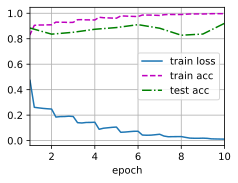

In [9]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())